#### Importing Packages

In [1]:
# import the necessary packages
import os
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

In [2]:
# initialize the initial learning rate, number of epochs to train for, and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

### Data Preprocessing

In [2]:
DIRECTORY = r"D:\Documents\Data Science\Face Mask Detector\dataset"
CATEGORIES = ["with_mask", "without_mask"]

print("Loading the dataset and processing it")

data = []
labels = []

Loading the dataset and processing it


#### Looping through all the images and categorizing them:

In [3]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path,img)
        image = load_img(img_path, target_size=(224,224))
        image = img_to_array(image)
        image = preprocess_input(image) 
        
        data.append(image)
        labels.append(category)

D:\Anaconda3\envs\yemel\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [4]:
len(data)

3833

#### One-Hot Encoding

In [6]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [7]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [8]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify = labels, random_state=42)

In [9]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

### Training

In [10]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

In [11]:
# construct the head of the model that will be placed on top of the the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [12]:
# loop over all layers in the base model and freeze them so they will*not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

# compile our model

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

print("Train the head of the network")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Train the head of the network
Epoch 1/20
95/95 [==============================] - 79s 829ms/step - loss: 0.3719 - accuracy: 0.8319 - val_loss: 0.1125 - val_accuracy: 0.9726
Epoch 2/20
95/95 [==============================] - 67s 710ms/step - loss: 0.1180 - accuracy: 0.9614 - val_loss: 0.0641 - val_accuracy: 0.9817
Epoch 3/20
95/95 [==============================] - 71s 745ms/step - loss: 0.0841 - accuracy: 0.9703 - val_loss: 0.0514 - val_accuracy: 0.9804
Epoch 4/20
95/95 [==============================] - 65s 682ms/step - loss: 0.0631 - accuracy: 0.9829 - val_loss: 0.0448 - val_accuracy: 0.9844
Epoch 5/20
95/95 [==============================] - 68s 714ms/step - loss: 0.0594 - accuracy: 0.9782 - val_loss: 0.0396 - val_accuracy: 0.9896
Epoch 6/20
95/95 [==============================] - 74s 782ms/step - loss: 0.0544 - accuracy: 0.9815 - val_loss: 0.0440 - val_accuracy: 0.9844
Epoch 7/20
95/95 [==============================] - 67s 710ms/step - loss: 0.0488 - accuracy: 0.9842 - val_loss:

#### Make predictions on the testing set

In [13]:
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

#### Classification report

In [14]:
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))
model.save("mask_detector.model", save_format="h5")

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



#### Plot the training loss and accuracy

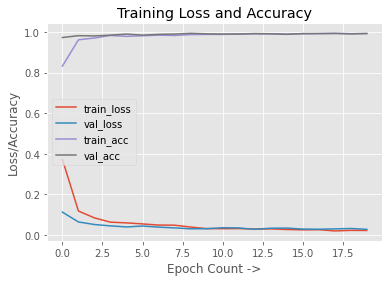

In [15]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch Count ->")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center left")
plt.savefig("plot.png")